In [1]:
import pandas as pd
import numpy as np

In [2]:
# This will allow you to see all column names & rows when you are doing .head(). None of the column name will be truncated.
# source: https://stackoverflow.com/questions/49188960/how-to-show-all-of-columns-name-on-pandas-dataframe

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [3]:
# source: https://gist.github.com/rozanecm/38f2901c592bdffc40726cb0473318cf
# Function which plays a beep of given duration and frequency.
# Useful for when executing things that need a while to finish, to get notified.
import os
def beep(duration = 1, freq = 1500):
    """ play tone of duration in seconds and freq in Hz. """
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))

In [4]:
train = pd.read_csv('../data/train.csv', dtype={'tipodepropiedad':'category', 'ciudad':'category', 'provincia':'category', 'id':'int32', 'antiguedad':'float16', 'habitaciones':'float16', 'garages':'float16', 'banos':'float16', 'metroscubiertos':'float16', 'metrostotales':'float16', 'idzona':'float16', 'lat':'float16', 'lng':'float16', 'gimnasio':'bool', 'usosmultiples':'bool', 'piscina':'bool', 'escuelascercanas':'bool', 'centroscomercialescercanos':'bool'}, parse_dates=['fecha']
#                     , nrows=1000
                   )
test = pd.read_csv('../data/test.csv', dtype={'tipodepropiedad':'category', 'ciudad':'category', 'provincia':'category', 'id':'int32', 'antiguedad':'float16', 'habitaciones':'float16', 'garages':'float16', 'banos':'float16', 'metroscubiertos':'float16', 'metrostotales':'float16', 'idzona':'float16', 'lat':'float16', 'lng':'float16', 'gimnasio':'bool', 'usosmultiples':'bool', 'piscina':'bool', 'escuelascercanas':'bool', 'centroscomercialescercanos':'bool'}, parse_dates=['fecha']
#                    , nrows=100
                  )
sample_submission = pd.read_csv('../data/ejemploRespuesta.csv')

In [5]:
rescued_coords = pd.read_csv('../data/rescueLatLongs.csv')
precios_en_dolares = pd.read_csv('../data/precios_en_dolares.csv')

In [6]:
# mergeamos con coords. extra obtenidas en tp1.
train = train.merge(rescued_coords.drop('Unnamed: 0', axis=1), how='left', on='id')
train['lat_x'] = train.apply(lambda x: x['lat_y'] if pd.isna(x['lat_x']) else x['lat_x'], axis=1)
train['lng_x'] = train.apply(lambda x: x['lng_y'] if pd.isna(x['lng_x']) else x['lng_x'], axis=1)
train.drop(['lat_y','lng_y'], axis=1, inplace=True)
train.rename(columns={'lat_x':'lat','lng_x':'lon'}, inplace=True)

# por consistencia, para que ambos datasets tengan mismos nombres
test.rename(columns={'lng':'lon'}, inplace=True)
train.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lon,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,NaN,2.0,1.0,2.0,80.0,80.0,23536.0,31.733330,-106.48333,2015-08-23,False,False,False,False,False,2273000.0
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.0,3.0,2.0,2.0,268.0,180.0,24512.0,19.312500,-99.25000,2013-06-28,False,False,False,True,True,3600000.0
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.0,3.0,2.0,2.0,144.0,166.0,48544.0,NaN,NaN,2015-10-17,False,False,False,False,False,1200000.0
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.0,2.0,1.0,1.0,63.0,67.0,53664.0,19.296875,-99.68750,2012-03-09,False,False,False,True,True,650000.0
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.0,2.0,1.0,1.0,95.0,95.0,47840.0,20.723560,-103.38479,2016-06-07,False,False,False,False,False,1150000.0


In [7]:
# inf. values don't make sense. I think it's preferable to treat them as nans directly.
train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Dolar

In [8]:
cotizaciones_train = pd.read_csv('../data/train_cotizaciones.csv')
cotizaciones_test = pd.read_csv('../data/test_cotizaciones.csv')

In [9]:
train = train.merge(cotizaciones_train)
test = test.merge(cotizaciones_test)

In [31]:
train['precio_dolares'] = train['precio'] / train['cotizacion_dolar']

# Agregamos features que ya hemos creado para analisis de tp1

In [11]:
def contar_amenities(row):
    return row['gimnasio'] + row['usosmultiples'] + row['piscina'] + row['escuelascercanas'] + row['centroscomercialescercanos']

In [12]:
train['cant_amenities'] = train.apply(lambda x: contar_amenities(x), axis=1)
test['cant_amenities'] = test.apply(lambda x: contar_amenities(x), axis=1)

In [13]:
palabras_avenida = ['avenida', 'av']
train['es_avenida'] = train['direccion'].fillna('no info').apply(lambda x: any(avenida_indicator in x.lower() for avenida_indicator in palabras_avenida))
test['es_avenida'] = test['direccion'].fillna('no info').apply(lambda x: any(avenida_indicator in x.lower() for avenida_indicator in palabras_avenida))

In [14]:
def feature_fechas(df, with_sin_cos=True):
    # Para entender lo de los senos y cosenos: https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
    df['year'] = df['fecha'].dt.year
    df['month'] = df['fecha'].dt.month
    df['day'] = df['fecha'].dt.day
    if with_sin_cos:
        df['sin_month'] = np.sin(2*np.pi*df['month']/12)
        df['cos_month'] = np.cos(2*np.pi*df['month']/12)
        # tomo cant. de dias en mes: 31 en todos los casos. Para esto deberia servir bastante bien igual.
        df['sin_day'] = np.sin(2*np.pi*df['day']/31)
        df['cos_day'] = np.cos(2*np.pi*df['day']/31)

        # no necesito mas las cols. originales de month y day.
        df.drop(['month','day'], axis=1, inplace=True)
    
feature_fechas(train)
feature_fechas(test)

# For approach 23
# feature_fechas(train, False)
# feature_fechas(test, False)

# * Fin agregado de features de tp1 *

El sample submission no tiene header. **Ojo con eso al guardar la submission.** Hagamos la funcion para guardar submissions ahora, para evitar problemas a futuro y despreocuparnos.

In [15]:
# To save predictions.
# There must be a directory ../predictions for this to work as expected.
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
import time
def _get_filename(my_name, timestamp):
    return "../predictions/" + timestamp + " by " + my_name + ".csv"

def _save_description(authors_name, timestamp, submission_description):
    f = open("../predictions/" + authors_name + ".txt","a")
    f.write(timestamp + ": " + submission_description + '\n')
    f.close()

def save_submission(submission_df, authors_name="rozanecm", description = "no description.", index=False, header=True):
    timestamp = time.strftime("%Y.%m.%d - %H:%M:%S")
    submission_df.to_csv(_get_filename(authors_name, timestamp), index=index, header=header)
    _save_description(authors_name, timestamp, description)

In [16]:
# Define a seed, so all algorithms that accept a seed, take the same, for consistency reasons,
# so everything can be replicated without problems random state
seed=42

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('precio', axis=1), train['precio'], test_size=0.33, random_state=seed)

In [18]:
beep()

# Approach 1: RandomForestRegressor

## Entrenamiento local

In [19]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
cat_columns = ['tipodepropiedad','ciudad','provincia']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida']

text_columns = ['titulo'
#                 ,'descripcion'
#                 ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.metrics import mean_absolute_error

transformers = []

# transformers.append(("cat",
#                      Pipeline(steps=[
#                          ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
#                          ("one_hot", OneHotEncoder(handle_unknown='ignore')),
#                      ]),
#                      cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.
# for col in text_columns_titulo:
# for col in text_columns:
#     # First, fill empty texts with an empty string.
#     X_train[col] = X_train[col].fillna("")
#     X_test[col] = X_test[col].fillna("")
#     transformer_name = "text_" + col
#     transformers.append((transformer_name,
#                         Pipeline(steps=[
#     #                         ("text_imputer", SimpleImputer(strategy='constant', fill_value="")),
#                             ("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii', 
# #                                                                      ngram_range=(2,5)
#                                                                     )),
#     #                         se podria agregar una svd.... o alguna proyeccion... 
#                         ]),
#                          col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

from sklearn.ensemble import RandomForestRegressor
steps.append(("rfr", RandomForestRegressor(n_estimators=100,
    n_jobs=-1,
    random_state=seed)))

my_pipe = Pipeline(steps, verbose=True)

In [ ]:
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

## Entrenamiento con todos los datos para obtener predicciones a subir

In [15]:
my_pipe.fit(train.drop(['precio'], axis=1).replace({True:1,False:0}), train['precio'])

# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.3s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 2.2min


In [16]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [85]:
# save_submission(df, description="first approach. Not taking any text atts. Random forest.")

In [17]:
description = "repeat first approach. This time, train with all the data. On previous runs, I trianed only with X_test, which is a part of the whole given train set."
save_submission(df, description=description)

In [19]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [20]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], 'approach_1':y_scores}))

df.to_csv('../predictions/on_train_data/rozanecm_approach_1',index=False, header=True)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.0s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 1.3min
773727.6079705233
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.1s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 1.3min
768614.1229419869
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.2s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 1.3min
765473.7160576448


In [21]:
beep()

# Approach 2

### Estudio var cat.: tipodepropiedad

In [102]:
enc = OneHotEncoder(handle_unknown='ignore')
aux = enc.fit_transform(train[['tipodepropiedad']].dropna())

In [103]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=22, n_iter=7, random_state=42)
svd.fit(aux)

TruncatedSVD(algorithm='randomized', n_components=22, n_iter=7, random_state=42,
             tol=0.0)

In [118]:
total_energy = np.sum(svd.singular_values_)
accumulated_energy = 0
i = 1
for singular_value in svd.singular_values_:
    accumulated_energy += singular_value
    print('current singular value:', singular_value)
    print("accumulated energy (%) till singular value n.", i, ":", accumulated_energy/total_energy)
    print("")
    i += 1

current singular value: 376.4531843397733
accumulated energy (%) till singular value n. 1 : 0.3058768243388757

current singular value: 239.45980873630234
accumulated energy (%) till singular value n. 2 : 0.5004433970231067

current singular value: 138.91364223860808
accumulated energy (%) till singular value n. 3 : 0.613313909248451

current singular value: 99.72462083154932
accumulated energy (%) till singular value n. 4 : 0.6943424450592185

current singular value: 55.27205442173929
accumulated energy (%) till singular value n. 5 : 0.7392522537273476

current singular value: 41.72529209005007
accumulated energy (%) till singular value n. 6 : 0.7731550080937372

current singular value: 37.49666651850506
accumulated energy (%) till singular value n. 7 : 0.803621907445616

current singular value: 37.36308338453927
accumulated energy (%) till singular value n. 8 : 0.8339802674451864

current singular value: 36.41428291206578
accumulated energy (%) till singular value n. 9 : 0.8635677053

Con el 11avo vs se retiene el 90% de la energia de la matriz, que es lo recomendado por Leskovec et al en su libro MMDS. Sin embargo, con el metodo grafico, se observa un codo con 6 valores ya. A pesar de esto, se elige 11 porque alli hay una especia de segundo codo, aunque un poco menor.

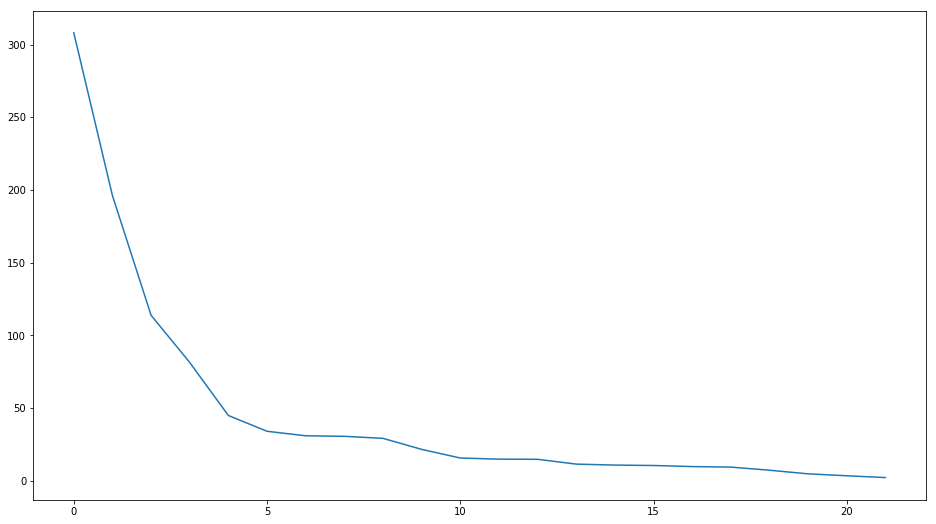

In [101]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
plt.plot(svd.singular_values_)
plt.show()

### Estudio var cat.: provincia

In [119]:
enc = OneHotEncoder(handle_unknown='ignore')
aux = enc.fit_transform(train[['provincia']].dropna())

In [120]:
aux

<239845x32 sparse matrix of type '<class 'numpy.float64'>'
	with 239845 stored elements in Compressed Sparse Row format>

In [122]:
from sklearn.decomposition import TruncatedSVD
# me quedo con todas las componentes para poder analizar cuantas dimensiones conviene retener
svd = TruncatedSVD(n_components=31, n_iter=7, random_state=42)
svd.fit(aux)

TruncatedSVD(algorithm='randomized', n_components=31, n_iter=7, random_state=42,
             tol=0.0)

In [123]:
total_energy = np.sum(svd.singular_values_)
accumulated_energy = 0
i = 1
for singular_value in svd.singular_values_:
    accumulated_energy += singular_value
    print('current singular value:', singular_value)
    print("accumulated energy (%) till singular value n.", i, ":", accumulated_energy/total_energy)
    print("")
    i += 1

current singular value: 242.46649253054727
accumulated energy (%) till singular value n. 1 : 0.1086471680396908

current singular value: 203.97793998381113
accumulated energy (%) till singular value n. 2 : 0.20004794383562494

current singular value: 145.7326318982503
accumulated energy (%) till singular value n. 3 : 0.2653494936764584

current singular value: 130.33802208101685
accumulated energy (%) till singular value n. 4 : 0.3237528501122475

current singular value: 123.79014500352044
accumulated energy (%) till singular value n. 5 : 0.37922215865664666

current singular value: 102.08329931973996
accumulated energy (%) till singular value n. 6 : 0.42496481472216685

current singular value: 91.90756225686378
accumulated energy (%) till singular value n. 7 : 0.4661478097678917

current singular value: 89.03931715819687
accumulated energy (%) till singular value n. 8 : 0.5060455686394899

current singular value: 85.65628990331258
accumulated energy (%) till singular value n. 9 : 0.54

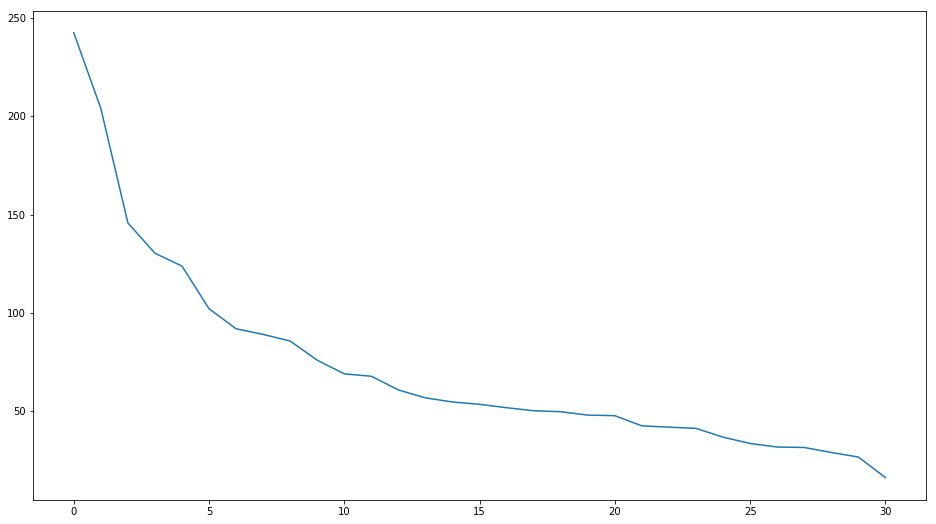

In [124]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
plt.plot(svd.singular_values_)
plt.show()

Segun las cuentas deberiamos retener 24 vs para retener el 90% de la energia. Como el total es 32, este nro. parece ser un poco excesivo. Por el metodo grafico se decide tomar nuevamente 11.

### Estudio var cat.: ciudad

In [15]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
aux = enc.fit_transform(train[['ciudad']].dropna())

In [16]:
aux

<239628x875 sparse matrix of type '<class 'numpy.float64'>'
	with 239628 stored elements in Compressed Sparse Row format>

Como no se puede calcular la svd de todos los componentes para obtener los valores singulares, se elige tomar 100 dimensiones.

## Entrenamiento local

In [22]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida']

text_columns = ['titulo'
#                 ,'descripcion'
#                 ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import mean_absolute_error

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.
# for col in text_columns_titulo:
# for col in text_columns:
#     # First, fill empty texts with an empty string.
#     X_train[col] = X_train[col].fillna("")
#     X_test[col] = X_test[col].fillna("")
#     transformer_name = "text_" + col
#     transformers.append((transformer_name,
#                         Pipeline(steps=[
#     #                         ("text_imputer", SimpleImputer(strategy='constant', fill_value="")),
#                             ("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii', 
# #                                                                      ngram_range=(2,5)
#                                                                     )),
#     #                         se podria agregar una svd.... o alguna proyeccion... 
#                         ]),
#                          col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

from sklearn.ensemble import RandomForestRegressor
steps.append(("rfr", RandomForestRegressor(n_estimators=100,
    n_jobs=-1,
    random_state=seed)))

my_pipe = Pipeline(steps, verbose=True)

In [22]:
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   5.4s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 2.7min
619151.4739815602


In [23]:
beep()

## Entrenamiento con todos los datos para obtener predicciones a subir

In [24]:
my_pipe.fit(train.drop(['precio'], axis=1).replace({True:1,False:0}), train['precio'])

# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   6.6s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 4.6min


In [25]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [26]:
description = "Second approach. Same as previous, but adding categorical features with one hot encoding + svd dim. red., to 11 dimensions in the small cases, and to 100 in the larger one. Algorithm is same as previously."
save_submission(df, description=description)

In [27]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [23]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_2"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   5.4s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 2.9min
613617.4667506837
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   7.9s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 3.1min
619893.2199777354
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   6.4s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 2.9min
611674.0503883368


In [24]:
beep()

# Approach 3. Texto.

## Entrenamiento local

In [25]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida']

text_columns = ['titulo'
                ,'descripcion'
                ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import mean_absolute_error

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.
# for col in text_columns_titulo:
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
#                             ("text_imputer", SimpleImputer(strategy='constant', fill_value="")),
                            ("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii', 
#                                                                      ngram_range=(2,5)
                                                                    )),
                            ("svd", TruncatedSVD(n_components=20, n_iter=7, random_state=seed))
    #                         se podria agregar una svd.... o alguna proyeccion... 
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

from sklearn.ensemble import RandomForestRegressor
steps.append(("rfr", RandomForestRegressor(n_estimators=100,
    n_jobs=-1,
    random_state=seed)))

my_pipe = Pipeline(steps, verbose=True)

In [17]:
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.0min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=14.4min
632879.1185852172


In [18]:
beep()

## Entrenamiento con todos los datos para obtener predicciones a subir

In [20]:
del X_train
del X_test
del y_train
del y_test

In [21]:
my_pipe.fit(train.drop(['precio'], axis=1).replace({True:1,False:0}), train['precio'])

# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.5min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=19.3min


In [22]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [23]:
description = "Third approach. Same as previous, but adding text features with one hashing vectorizer + svd dim. red. Algorithm is same as previously."
save_submission(df, description=description)

In [24]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [26]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_3"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.4min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=11.9min
627943.7597431771
[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.4min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=12.1min
633384.3494840289
[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.1min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=12.0min
624686.8034252054


In [27]:
beep()

# Approach 4. Texto, como antes, pero con spanish stopwords.

## Entrenamiento local

In [28]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida']

text_columns = ['titulo'
                ,'descripcion'
                ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from stop_words import get_stop_words
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import mean_absolute_error

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.
# for col in text_columns_titulo:
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
#                             ("text_imputer", SimpleImputer(strategy='constant', fill_value="")),
                            ("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii', stop_words=get_stop_words('spanish'),
#                                                                      ngram_range=(2,5)
                                                                    )),
                            ("svd", TruncatedSVD(n_components=20, n_iter=7, random_state=seed))
    #                         se podria agregar una svd.... o alguna proyeccion... 
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

from sklearn.ensemble import RandomForestRegressor
steps.append(("rfr", RandomForestRegressor(n_estimators=100,
    n_jobs=-1,
    random_state=seed)))

my_pipe = Pipeline(steps, verbose=True)

In [17]:
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.0min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=14.4min
632879.1185852172


In [18]:
beep()

## Entrenamiento con todos los datos para obtener predicciones a subir

In [20]:
del X_train
del X_test
del y_train
del y_test

In [43]:
my_pipe.fit(train.drop(['precio'], axis=1).replace({True:1,False:0}), train['precio'])

# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.4min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=21.3min


In [44]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [45]:
description = "4th approach. Same as previous, but adding spanish stopwords."
save_submission(df, description=description)

In [46]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [29]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_4"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.1min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=13.3min
618939.2789953533
[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.8min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=12.6min
624002.7352707502
[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.3min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=11.7min
618190.7985218797


In [30]:
beep()

# [pendiente] Approach 5. Texto. THT con n-gramas

## Entrenamiento local

In [17]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida']

text_columns = ['titulo'
                ,'descripcion'
                ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import mean_absolute_error

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.
# for col in text_columns_titulo:
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
#                             ("text_imputer", SimpleImputer(strategy='constant', fill_value="")),
                            ("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii', 
                                                                     ngram_range=(2,5)
                                                                    )),
                            ("svd", TruncatedSVD(n_components=20, n_iter=7, random_state=seed))
    #                         se podria agregar una svd.... o alguna proyeccion... 
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

from sklearn.ensemble import RandomForestRegressor
steps.append(("rfr", RandomForestRegressor(n_estimators=100,
    n_jobs=-1,
    random_state=seed)))

my_pipe = Pipeline(steps, verbose=True)

In [17]:
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.0min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=14.4min
632879.1185852172


In [18]:
beep()

## Entrenamiento con todos los datos para obtener predicciones a subir

In [20]:
del X_train
del X_test
del y_train
del y_test

In [21]:
my_pipe.fit(train.drop(['precio'], axis=1).replace({True:1,False:0}), train['precio'])

# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.5min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=19.3min


In [22]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [23]:
description = "Third approach. Same as previous, but adding text features with one hashing vectorizer + svd dim. red. Algorithm is same as previously."
save_submission(df, description=description)

In [24]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [25]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_5"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 2.6min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=14.1min
627943.7597431771
[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.7min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=12.8min
633384.3494840289
[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.3min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=12.2min
624686.8034252054


In [30]:
beep()

# [pendiente] Approach 6. Texto: Tf-idf
El approach se encuentra pendiente porque tardaba demasiado tiempo tanto localmente como en Kaggle.

## Entrenamiento local

In [51]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida']

text_columns = ['titulo'
                ,'descripcion'
                ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.
# for col in text_columns_titulo:
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
#                             ("text_imputer", SimpleImputer(strategy='constant', fill_value="")),
                            ("tf-idf", TfidfVectorizer(decode_error='ignore')),
                            ("svd", TruncatedSVD(n_components=20, n_iter=7, random_state=seed))
    #                         se podria agregar una svd.... o alguna proyeccion... 
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

from sklearn.ensemble import RandomForestRegressor
steps.append(("rfr", RandomForestRegressor(n_estimators=100,
    n_jobs=-1,
    random_state=seed)))

my_pipe = Pipeline(steps, verbose=True)

# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.8min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=29.4min


KeyboardInterrupt: 

In [ ]:
beep()

## Entrenamiento con todos los datos para obtener predicciones a subir

In [21]:
my_pipe.fit(train.drop(['precio'], axis=1).replace({True:1,False:0}), train['precio'])

# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.5min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=19.3min


In [22]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [23]:
description = "Third approach. Same as previous, but adding text features with one hashing vectorizer + svd dim. red. Algorithm is same as previously."
save_submission(df, description=description)

In [24]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [25]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_6"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 2.6min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=14.1min
627943.7597431771
[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.7min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=12.8min
633384.3494840289
[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.3min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=12.2min
624686.8034252054


In [30]:
beep()

Este approach con tf-idf tardo mucho localmente, y cuando se intento en kaggle

# Approach 7: LightGBM

## Entrenamiento local

In [27]:
X_train.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lon', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'cant_amenities', 'year', 'sin_month',
       'cos_month', 'sin_day', 'cos_day', 'es_avenida'],
      dtype='object')

In [31]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1,
                        n_estimators=100, subsample_for_bin=200000, objective=None,
                        class_weight=None, min_split_gain=0.0, min_child_weight=0.001,
                        min_child_samples=20, subsample=1.0, subsample_freq=0,
                        colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,
                        random_state=seed, n_jobs=-1, silent=True, importance_type='split')

In [30]:
gbm.fit(X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train, sample_weight=None, init_score=None, eval_set=[(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1),y_test)], eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=10,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)

y_scores = gbm.predict(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm.best_iteration_)

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


600626.0514709201


In [22]:
gbm.feature_importances_

array([ 75, 160,  79,  86,  23,  80,  52,  37,  67,  48,  57,  30,  60,
        20,  14,  19,  32,  26,  28,  18,  54,  27,  10,  67,   9,  16,
         8,  51,  25,  14,  11,  20,  25,  15,  48,  27, 126,  82,  45,
        73, 391, 296, 207,  60,  49,  10, 116,  18,  16,   8,   8,  20,
         1,  19,   3,  11,   3], dtype=int32)

In [23]:
gbm.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('l1', 776563.1877915304),
                          ('l2', 1588195087055.7976)])})

In [ ]:
beep()

## Entrenamiento con todos los datos para obtener predicciones a subir

In [32]:
gbm.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio'],axis=1), train['precio'], sample_weight=None, init_score=None, eval_set=None, eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)


# prediciendo valores posta...
predictions = gbm.predict(test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm.best_iteration_)

In [33]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [34]:
description = "7th approach. LightGBM"
save_submission(df, description=description)

In [27]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [33]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_7"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    gbm.fit(X_train2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train2)
    y_scores = gbm.predict(X_test2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

601903.1787852186
606405.0221414941
602955.8643765596


In [30]:
beep()

# Approach 8: LightGBM with parameter tuning

## Entrenamiento local

Nos basamos, para el parameter tuning, en lo propuesto en https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db.

In [27]:
X_train.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lon', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'cant_amenities', 'year', 'sin_month',
       'cos_month', 'sin_day', 'cos_day', 'es_avenida'],
      dtype='object')

In [42]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
gbm = lgb.LGBMRegressor(silent=False)

param_dist = {"max_depth": [25,50, 75],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [300,900,1200],
              "n_estimators": [50,100,200]
             }

grid_search = GridSearchCV(gbm, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="neg_mean_absolute_error", verbose=5)
grid_search.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio'],axis=1), train['precio'])
grid_search.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 14.0min
/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 44.5min finished


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=75,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=1200, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [34]:
gbm_optimized = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=75,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=1200, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [41]:
import sklearn
# possible scorings
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [49]:
gbm_optimized.fit(X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train, sample_weight=None, init_score=None, eval_set=[(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1),y_test)], eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=10,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)

y_scores = gbm_optimized.predict(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


544873.704958181


In [ ]:
beep()

## Entrenamiento con todos los datos para obtener predicciones a subir

In [50]:
gbm_optimized.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio'],axis=1), train['precio'], sample_weight=None, init_score=None, eval_set=None, eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)


# prediciendo valores posta...
predictions = gbm_optimized.predict(test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [51]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [52]:
description = "8th approach. LightGBM with grid search."
save_submission(df, description=description)

In [53]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [35]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_8"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    gbm_optimized.fit(X_train2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train2)
    y_scores = gbm_optimized.predict(X_test2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

545473.9031255319
549068.6693557157
543951.0616743357


In [36]:
beep()

# [pendiente] Approach 9: busco hiperp. del app. 2.

## Entrenamiento local

In [ ]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida']

text_columns = ['titulo'
#                 ,'descripcion'
#                 ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.
# for col in text_columns_titulo:
# for col in text_columns:
#     # First, fill empty texts with an empty string.
#     X_train[col] = X_train[col].fillna("")
#     X_test[col] = X_test[col].fillna("")
#     transformer_name = "text_" + col
#     transformers.append((transformer_name,
#                         Pipeline(steps=[
#     #                         ("text_imputer", SimpleImputer(strategy='constant', fill_value="")),
#                             ("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii', 
# #                                                                      ngram_range=(2,5)
#                                                                     )),
#     #                         se podria agregar una svd.... o alguna proyeccion... 
#                         ]),
#                          col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

my_pipe = Pipeline(steps, verbose=True)

In [ ]:
# .replace is introduced because algorithms need numbers; booleans don't make it.
train_transformed = my_pipe.fit_transform(train.iloc[:10000].drop('precio',axis=1).replace({True:1,False:0}), train.iloc[:10000]['precio'])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_jobs=-1, random_state=seed, criterion='mae', verbose=1)

param_dist = {"bootstrap":[True,False],
#               "max_depth": [25,50,75],
#               "min_samples_split": [3,8],
#               "min_samples_leaf": [1,4],
              "max_features": ["auto","sqrt"],
              "n_estimators": [50,100,150,200]
             }

grid_search = GridSearchCV(rfr, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="neg_mean_absolute_error", verbose=5)
grid_search.fit(train_transformed, train.iloc[:10000]['precio'])
grid_search.best_estimator_

In [ ]:
beep()

Grid search arranca a las casi 15.00

## Entrenamiento con todos los datos para obtener predicciones a subir

In [ ]:
my_pipe.fit(train.drop(['precio'], axis=1).replace({True:1,False:0}), train['precio'])

# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

In [ ]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [ ]:
description = "Second approach. Same as previous, but adding categorical features with one hot encoding + svd dim. red., to 11 dimensions in the small cases, and to 100 in the larger one. Algorithm is same as previously."
save_submission(df, description=description)

In [ ]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_9"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

In [ ]:
beep()

# Approach 10: catboost with parameter tuning

## Entrenamiento local

Nos basamos, para el parameter tuning, en lo propuesto en https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db.

In [28]:
train.dtypes

id                                     int64
titulo                                object
descripcion                           object
tipodepropiedad                     category
direccion                             object
ciudad                              category
provincia                           category
antiguedad                           float16
habitaciones                         float16
garages                              float16
banos                                float16
metroscubiertos                      float16
metrostotales                        float16
idzona                               float16
lat                                  float64
lon                                  float64
fecha                         datetime64[ns]
gimnasio                                bool
usosmultiples                           bool
piscina                                 bool
escuelascercanas                        bool
centroscomercialescercanos              bool
precio    

In [1]:
# Hecho en kaggle
# from sklearn.model_selection import GridSearchCV
# import catboost as cb
# cbr = cb.CatBoostRegressor(loss_function='MAE')

# params = {'depth': [4, 7, 10],
#           'learning_rate' : [0.03, 0.1, 0.15],
#          'l2_leaf_reg': [1,4,9],
#          'iterations': [300]}

# grid_search = GridSearchCV(cbr, n_jobs=-1, param_grid=params, cv = 3, scoring="neg_mean_absolute_error", verbose=5)
# grid_search.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio','tipodepropiedad','ciudad','provincia'],axis=1), train['precio'])
# grid_search.best_estimator_

In [38]:
import catboost as cb
cbr_optimized = cb.CatBoostRegressor(loss_function='MAE', depth= 10, iterations= 600, l2_leaf_reg= 4, learning_rate= 0.15)

In [ ]:
cbr_optimized.fit(X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad','ciudad','provincia'],axis=1), y_train)

y_scores = cbr_optimized.predict(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad','ciudad','provincia'],axis=1))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

In [ ]:
beep()

## Entrenamiento con todos los datos para obtener predicciones a subir

In [49]:
cbr_optimized.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio','tipodepropiedad','ciudad','provincia'],axis=1), train['precio'])

In [50]:
# prediciendo valores posta...
predictions = cbr_optimized.predict(test.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad','ciudad','provincia'],axis=1))

In [51]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [52]:
description = "10th approach. Catboost with grid search."
save_submission(df, description=description)

In [ ]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_10"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    cbr_optimized.fit(X_train2.drop(['id','fecha','titulo', 'descripcion', 'direccion', 'tipodepropiedad','ciudad','provincia'],axis=1), y_train2)
    y_scores = cbr_optimized.predict(X_test2.drop(['id','fecha','titulo', 'descripcion', 'direccion', 'tipodepropiedad','ciudad','provincia'],axis=1))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

La celda superior se corrio, pero se hizo clear output porque resultaba muy molesto el output.

In [45]:
beep()

# Approach 11: SVM, LinearSVR

## Entrenamiento local

In [16]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida']

text_columns = ['titulo'
#                 ,'descripcion'
#                 ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import mean_absolute_error

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.
# for col in text_columns:
#     # First, fill empty texts with an empty string.
#     X_train[col] = X_train[col].fillna("")
#     X_test[col] = X_test[col].fillna("")
#     transformer_name = "text_" + col
#     transformers.append((transformer_name,
#                         Pipeline(steps=[
#     #                         ("text_imputer", SimpleImputer(strategy='constant', fill_value="")),
#                             ("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii', 
# #                                                                      ngram_range=(2,5)
#                                                                     )),
#     #                         se podria agregar una svd.... o alguna proyeccion... 
#                         ]),
#                          col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

my_pipe = Pipeline(steps, verbose=True)

In [17]:
train_transformed = my_pipe.fit_transform(train.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 1) Processing col_trans, total=   8.4s


In [18]:
from sklearn.svm import LinearSVR
lsvr = LinearSVR(random_state=seed, verbose=True)

In [19]:
from sklearn.model_selection import GridSearchCV 
param_dist = {"epsilon":[0.0],
              "tol":[0.0001,0.001],
              "C":[0.1,1.0,10],
              "loss":['epsilon_insensitive','squared_epsilon_insensitive'],
              "max_iter":[100,1000,10000],
             }

grid_search = GridSearchCV(lsvr, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="neg_mean_absolute_error", verbose=5)
grid_search.fit(train_transformed, train['precio'])
grid_search.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 49.5min finished


[LibLinear]

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=10, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='squared_epsilon_insensitive',
          max_iter=10000, random_state=42, tol=0.0001, verbose=True)

In [20]:
lsvr_optimized = grid_search.best_estimator_

steps.append(("lsvr", lsvr_optimized))

my_pipe = Pipeline(steps, verbose=True)

In [21]:
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   5.5s
[LibLinear]

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Pipeline] .............. (step 2 of 2) Processing lsvr, total=11.0min
897657.6795846864


## Entrenamiento con todos los datos para obtener predicciones a subir

In [22]:
my_pipe.fit(train.drop(['precio'], axis=1).replace({True:1,False:0}), train['precio'])

# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   6.6s
[LibLinear]

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Pipeline] .............. (step 2 of 2) Processing lsvr, total=16.4min


In [23]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [24]:
description = "11th approach. SVM: LinearSVR with grid search."
save_submission(df, description=description)

In [25]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [26]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_11"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   5.1s
[LibLinear]

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Pipeline] .............. (step 2 of 2) Processing lsvr, total=10.7min
897340.5487136106
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   5.2s
[LibLinear]

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Pipeline] .............. (step 2 of 2) Processing lsvr, total=10.5min
902922.7016598013
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   5.1s
[LibLinear]

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Pipeline] .............. (step 2 of 2) Processing lsvr, total=10.5min
898199.4511563196


In [27]:
beep()

# Approach 12: SVM, SVR

## Entrenamiento local

In [28]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida']

text_columns = ['titulo'
#                 ,'descripcion'
#                 ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import mean_absolute_error

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))


transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.
# for col in text_columns:
#     # First, fill empty texts with an empty string.
#     X_train[col] = X_train[col].fillna("")
#     X_test[col] = X_test[col].fillna("")
#     transformer_name = "text_" + col
#     transformers.append((transformer_name,
#                         Pipeline(steps=[
#     #                         ("text_imputer", SimpleImputer(strategy='constant', fill_value="")),
#                             ("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii', 
# #                                                                      ngram_range=(2,5)
#                                                                     )),
#     #                         se podria agregar una svd.... o alguna proyeccion... 
#                         ]),
#                          col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

my_pipe = Pipeline(steps, verbose=True)

In [29]:
train_transformed = my_pipe.fit_transform(train.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 1) Processing col_trans, total=   6.7s


In [30]:
from sklearn.svm import SVR
svr = SVR(verbose=True)

In [31]:
from sklearn.model_selection import GridSearchCV 
param_dist = {"kernel":['linear', 'poly', 'rbf', 'sigmoid'],
#               "degree":[3,5],
#               "gamma":['auto','scale'],
#               "tol":[0.01,0.001],
#               "C":[0.1,1.0,10],
#               "shrinking":[True,False],
             }

grid_search = GridSearchCV(svr, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="neg_mean_absolute_error", verbose=5)
grid_search.fit(train_transformed, train['precio'])
grid_search.best_estimator_

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 306.1min


KeyboardInterrupt: 

In [ ]:
lsvr_optimized = grid_search.best_estimator_

steps.append(("lsvr", lsvr_optimized))

my_pipe = Pipeline(steps, verbose=True)

In [ ]:
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

## Entrenamiento con todos los datos para obtener predicciones a subir

In [ ]:
my_pipe.fit(train.drop(['precio'], axis=1).replace({True:1,False:0}), train['precio'])

# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

In [ ]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [ ]:
description = "12th approach. SVM: SVR with grid search."
save_submission(df, description=description)

In [ ]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_12"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

In [ ]:
beep()

# Approach 13: HistGradientBoostingRegressor

## Entrenamiento local

In [ ]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida']

text_columns = ['titulo'
#                 ,'descripcion'
#                 ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import mean_absolute_error

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.
# for col in text_columns:
#     # First, fill empty texts with an empty string.
#     X_train[col] = X_train[col].fillna("")
#     X_test[col] = X_test[col].fillna("")
#     transformer_name = "text_" + col
#     transformers.append((transformer_name,
#                         Pipeline(steps=[
#     #                         ("text_imputer", SimpleImputer(strategy='constant', fill_value="")),
#                             ("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii', 
# #                                                                      ngram_range=(2,5)
#                                                                     )),
#     #                         se podria agregar una svd.... o alguna proyeccion... 
#                         ]),
#                          col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

my_pipe = Pipeline(steps, verbose=True)

In [ ]:
train_transformed = my_pipe.fit_transform(train.replace({True:1,False:0}))

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
hgbr = HistGradientBoostingRegressor(scoring='neg_mean_absolute_error', verbose=1, random_state=seed)

In [ ]:
from sklearn.model_selection import GridSearchCV 
param_dist = {"learning_rate":[0.01,0.1],
              "max_iter":[75,150,230],
              "max_depth":[2,5],
              "min_samples_leaf":[20,40],
              "l2_regularization":[0.0,0.5],
             }

grid_search = GridSearchCV(hgbr, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="neg_mean_absolute_error", verbose=5)
grid_search.fit(train_transformed, train['precio'])
grid_search.best_estimator_

In [ ]:
hgbr_optimized = grid_search.best_estimator_

steps.append(("hgbr", hgbr_optimized))

my_pipe = Pipeline(steps, verbose=True)

In [ ]:
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

## Entrenamiento con todos los datos para obtener predicciones a subir

In [ ]:
my_pipe.fit(train.drop(['precio'], axis=1).replace({True:1,False:0}), train['precio'])

# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

In [ ]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [ ]:
description = "13th approach. HistGradientBoostingRegressor with grid search."
save_submission(df, description=description)

In [ ]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_13"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

In [ ]:
beep()

# Approach 14: LinearRegression

## Entrenamiento local

In [16]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida']

text_columns = ['titulo'
#                 ,'descripcion'
#                 ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import mean_absolute_error

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.
# for col in text_columns:
#     # First, fill empty texts with an empty string.
#     X_train[col] = X_train[col].fillna("")
#     X_test[col] = X_test[col].fillna("")
#     transformer_name = "text_" + col
#     transformers.append((transformer_name,
#                         Pipeline(steps=[
#     #                         ("text_imputer", SimpleImputer(strategy='constant', fill_value="")),
#                             ("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii', 
# #                                                                      ngram_range=(2,5)
#                                                                     )),
#     #                         se podria agregar una svd.... o alguna proyeccion... 
#                         ]),
#                          col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

my_pipe = Pipeline(steps, verbose=True)

In [17]:
train_transformed = my_pipe.fit_transform(train.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 1) Processing col_trans, total=   2.8s


In [19]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(n_jobs=-1)

In [20]:
from sklearn.model_selection import GridSearchCV 
param_dist = {"fit_intercept":[True, False],
              "normalize":[True, False],
             }

grid_search = GridSearchCV(lr, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="neg_mean_absolute_error", verbose=5)
grid_search.fit(train_transformed, train['precio'])
grid_search.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  12 | elapsed:    3.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.0s finished


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=-1, normalize=True)

In [21]:
lr_optimized = grid_search.best_estimator_

steps.append(("lr", lr_optimized))

my_pipe = Pipeline(steps, verbose=True)

In [22]:
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.9s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.0s
1016155.8305220593


## Entrenamiento con todos los datos para obtener predicciones a subir

In [23]:
my_pipe.fit(train.drop(['precio'], axis=1).replace({True:1,False:0}), train['precio'])

# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.8s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.0s


In [24]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [ ]:
description = "14th approach. LinearRegression with grid search."
save_submission(df, description=description)

In [ ]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [25]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_14"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.7s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.0s
1001673.3970424968
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.8s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.0s
980169.324595118
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   3.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.1s
997312.9969221317


In [ ]:
beep()

# Approach 15: SGDRegressor

## Entrenamiento local

In [29]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida']

text_columns = ['titulo'
#                 ,'descripcion'
#                 ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import mean_absolute_error

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.
# for col in text_columns:
#     # First, fill empty texts with an empty string.
#     X_train[col] = X_train[col].fillna("")
#     X_test[col] = X_test[col].fillna("")
#     transformer_name = "text_" + col
#     transformers.append((transformer_name,
#                         Pipeline(steps=[
#     #                         ("text_imputer", SimpleImputer(strategy='constant', fill_value="")),
#                             ("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii', 
# #                                                                      ngram_range=(2,5)
#                                                                     )),
#     #                         se podria agregar una svd.... o alguna proyeccion... 
#                         ]),
#                          col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

my_pipe = Pipeline(steps, verbose=True)

In [30]:
train_transformed = my_pipe.fit_transform(train.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 1) Processing col_trans, total=   3.3s


In [40]:
from sklearn.linear_model import SGDRegressor
sgdr = SGDRegressor(random_state=seed)

In [41]:
from sklearn.model_selection import GridSearchCV 
param_dist = {"learning_rate":['constant','optimal','invscaling','adaptive'],
              "eta0":[0.001, 0.01, 0.1],
             }

grid_search = GridSearchCV(sgdr, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="neg_mean_absolute_error", verbose=5)
grid_search.fit(train_transformed, train['precio'])
grid_search.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    3.7s finished
/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.001, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [42]:
sgdr_optimized = grid_search.best_estimator_

steps.append(("sgdr", sgdr_optimized))

my_pipe = Pipeline(steps, verbose=True)

In [43]:
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.9s


/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] .............. (step 2 of 2) Processing sgdr, total=   0.2s
1016909.1250496904


## Entrenamiento con todos los datos para obtener predicciones a subir

In [44]:
my_pipe.fit(train.drop(['precio'], axis=1).replace({True:1,False:0}), train['precio'])

# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   3.1s


/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] .............. (step 2 of 2) Processing sgdr, total=   0.3s


In [45]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [ ]:
description = "15th approach. SGDRegressor with grid search."
save_submission(df, description=description)

In [ ]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [46]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_15"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   3.6s


/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] .............. (step 2 of 2) Processing sgdr, total=   0.2s
1007637.8512633618
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.9s


/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] .............. (step 2 of 2) Processing sgdr, total=   0.2s
966123.4299893609
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   5.5s


/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] .............. (step 2 of 2) Processing sgdr, total=   0.4s
978685.9263156453


In [ ]:
beep()

# Approach 16: BaggingRegressor

## Entrenamiento local

In [47]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida']

text_columns = ['titulo'
#                 ,'descripcion'
#                 ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import mean_absolute_error

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.
# for col in text_columns:
#     # First, fill empty texts with an empty string.
#     X_train[col] = X_train[col].fillna("")
#     X_test[col] = X_test[col].fillna("")
#     transformer_name = "text_" + col
#     transformers.append((transformer_name,
#                         Pipeline(steps=[
#     #                         ("text_imputer", SimpleImputer(strategy='constant', fill_value="")),
#                             ("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii', 
# #                                                                      ngram_range=(2,5)
#                                                                     )),
#     #                         se podria agregar una svd.... o alguna proyeccion... 
#                         ]),
#                          col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

my_pipe = Pipeline(steps, verbose=True)

In [48]:
train_transformed = my_pipe.fit_transform(train.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 1) Processing col_trans, total=   3.3s


In [51]:
from sklearn.ensemble import BaggingRegressor
br = BaggingRegressor(n_jobs=-1, verbose=5, random_state=seed, bootstrap_features=True)

In [52]:
from sklearn.model_selection import GridSearchCV 
param_dist = {"n_estimators":[10,30,50],
              "max_samples":[0.8, 1.0],
              "max_features":[0.8, 1.0],
              "oob_score":[True, False]
             }

grid_search = GridSearchCV(br, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="neg_mean_absolute_error", verbose=5)
grid_search.fit(train_transformed, train['precio'])
grid_search.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   19.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.5s remaining:    2.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.5s finished


BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=True,
                 max_features=1.0, max_samples=1.0, n_estimators=50, n_jobs=-1,
                 oob_score=True, random_state=42, verbose=5, warm_start=False)

In [54]:
br_optimized = grid_search.best_estimator_

steps.append(("br", br_optimized))

my_pipe = Pipeline(steps, verbose=True)

In [55]:
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.7s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.2s remaining:    2.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.2s finished


[Pipeline] ................ (step 2 of 2) Processing br, total=   2.7s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


922136.5407878787


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.8s finished


## Entrenamiento con todos los datos para obtener predicciones a subir

In [56]:
my_pipe.fit(train.drop(['precio'], axis=1).replace({True:1,False:0}), train['precio'])

# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   3.8s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.7s finished


[Pipeline] ................ (step 2 of 2) Processing br, total=   3.1s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.2s remaining:    2.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.4s finished


In [57]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [ ]:
description = "16th approach. BaggingRegressor with grid search."
save_submission(df, description=description)

In [ ]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [58]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_16"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   3.4s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.5s remaining:    2.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.5s finished


[Pipeline] ................ (step 2 of 2) Processing br, total=   3.1s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.0s remaining:    2.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.1s finished


912608.6894610778
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.8s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.2s remaining:    2.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.3s finished


[Pipeline] ................ (step 2 of 2) Processing br, total=   2.8s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.2s finished


861136.3882882884
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.7s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.2s finished


[Pipeline] ................ (step 2 of 2) Processing br, total=   2.7s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


931269.3018618618


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.8s remaining:    1.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.9s finished


In [ ]:
beep()

# Approach 17: ExtraTreesRegressor

## Entrenamiento local

In [71]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida']

text_columns = ['titulo'
#                 ,'descripcion'
#                 ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import mean_absolute_error

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.
# for col in text_columns:
#     # First, fill empty texts with an empty string.
#     X_train[col] = X_train[col].fillna("")
#     X_test[col] = X_test[col].fillna("")
#     transformer_name = "text_" + col
#     transformers.append((transformer_name,
#                         Pipeline(steps=[
#     #                         ("text_imputer", SimpleImputer(strategy='constant', fill_value="")),
#                             ("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii', 
# #                                                                      ngram_range=(2,5)
#                                                                     )),
#     #                         se podria agregar una svd.... o alguna proyeccion... 
#                         ]),
#                          col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

my_pipe = Pipeline(steps, verbose=True)

In [72]:
train_transformed = my_pipe.fit_transform(train.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 1) Processing col_trans, total=   2.9s


In [68]:
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(n_jobs=-1, random_state=seed, criterion='mae')

In [69]:
from sklearn.model_selection import GridSearchCV 
param_dist = {"n_estimators":[10,60,120],
              "min_samples_split":[0.2, 0.01],
              "min_samples_leaf":[0.2, 0.01],
             }

grid_search = GridSearchCV(etr, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="neg_mean_absolute_error", verbose=5)
grid_search.fit(train_transformed, train['precio'])
grid_search.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   36.0s finished


ExtraTreesRegressor(bootstrap=False, criterion='mae', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=0.01, min_samples_split=0.01,
                    min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=-1,
                    oob_score=False, random_state=42, verbose=0,
                    warm_start=False)

In [73]:
etr_optimized = grid_search.best_estimator_

steps.append(("etr", etr_optimized))

my_pipe = Pipeline(steps, verbose=True)

In [74]:
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.9s
[Pipeline] ............... (step 2 of 2) Processing etr, total=   3.5s
898540.3505934343


## Entrenamiento con todos los datos para obtener predicciones a subir

In [75]:
my_pipe.fit(train.drop(['precio'], axis=1).replace({True:1,False:0}), train['precio'])

# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   3.3s
[Pipeline] ............... (step 2 of 2) Processing etr, total=   6.5s


In [76]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [ ]:
description = "17th approach. ExtraTreesRegressor with grid search."
save_submission(df, description=description)

In [ ]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [77]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_17"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   3.3s
[Pipeline] ............... (step 2 of 2) Processing etr, total=   3.4s
896779.2017964071
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.9s
[Pipeline] ............... (step 2 of 2) Processing etr, total=   3.9s
869472.3741866866
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   3.3s
[Pipeline] ............... (step 2 of 2) Processing etr, total=   3.8s
837984.0880755755


In [ ]:
beep()

# Approach 18: GradientBoostingRegressor

## Entrenamiento local

In [78]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida']

text_columns = ['titulo'
#                 ,'descripcion'
#                 ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import mean_absolute_error

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.
# for col in text_columns:
#     # First, fill empty texts with an empty string.
#     X_train[col] = X_train[col].fillna("")
#     X_test[col] = X_test[col].fillna("")
#     transformer_name = "text_" + col
#     transformers.append((transformer_name,
#                         Pipeline(steps=[
#     #                         ("text_imputer", SimpleImputer(strategy='constant', fill_value="")),
#                             ("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii', 
# #                                                                      ngram_range=(2,5)
#                                                                     )),
#     #                         se podria agregar una svd.... o alguna proyeccion... 
#                         ]),
#                          col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

my_pipe = Pipeline(steps, verbose=True)

In [79]:
train_transformed = my_pipe.fit_transform(train.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 1) Processing col_trans, total=   2.4s


In [89]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=seed, criterion='mae', n_estimators=400)

In [90]:
from sklearn.model_selection import GridSearchCV 
param_dist = {"learning_rate":[0.001, 0.01, 0.1],
#               "n_estimators":[100,400],
#               "min_samples_split":[0.2, 0.01],
#               "min_samples_leaf":[0.2, 0.01],
             }

grid_search = GridSearchCV(gbr, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="neg_mean_absolute_error", verbose=5)
grid_search.fit(train_transformed, train['precio'])
grid_search.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  1.1min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  2.3min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  3.0min finished


GradientBoostingRegressor(alpha=0.9, criterion='mae', init=None,
                          learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=400,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [91]:
gbr_optimized = grid_search.best_estimator_

steps.append(("gbr", gbr_optimized))

my_pipe = Pipeline(steps, verbose=True)

In [92]:
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   4.4s
[Pipeline] ............... (step 2 of 2) Processing gbr, total=  46.0s
952012.5443824494


## Entrenamiento con todos los datos para obtener predicciones a subir

In [93]:
my_pipe.fit(train.drop(['precio'], axis=1).replace({True:1,False:0}), train['precio'])

# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   4.2s
[Pipeline] ............... (step 2 of 2) Processing gbr, total= 1.5min


In [94]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [ ]:
description = "18th approach. GradientBoostingRegressor with grid search."
save_submission(df, description=description)

In [ ]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [95]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_18"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

# df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   4.2s
[Pipeline] ............... (step 2 of 2) Processing gbr, total=  41.2s
935815.5332137742
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   4.1s
[Pipeline] ............... (step 2 of 2) Processing gbr, total=  44.3s
888504.1757463134
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   3.7s
[Pipeline] ............... (step 2 of 2) Processing gbr, total=  41.6s
881234.7915145378


In [96]:
beep()

# Approach 19: LightGBM with log price

## Entrenamiento local

In [16]:
import seaborn as sns

import matplotlib.pyplot as plt

In [17]:
train.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lon', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio', 'cant_amenities', 'year',
       'sin_month', 'cos_month', 'sin_day', 'cos_day', 'es_avenida'],
      dtype='object')

In [18]:
import scipy.stats as st
from scipy.stats import skew, skewtest

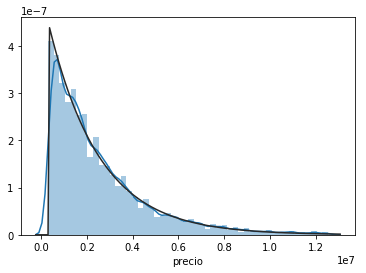

In [19]:
sns.distplot(train['precio'], hist=True, rug=False, fit=st.expon);

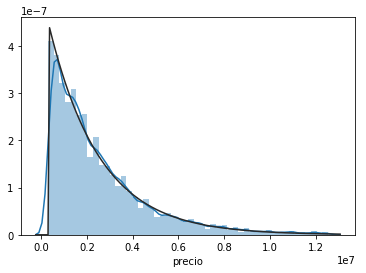

In [20]:
sns.distplot(train['precio'], hist=True, rug=False, fit=st.expon);

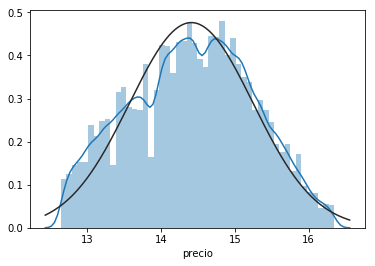

In [21]:
sns.distplot(np.log(train['precio'].dropna()), hist=True, rug=False, fit=st.norm);

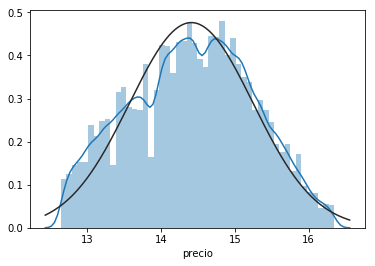

In [22]:
sns.distplot(np.log(train['precio'].dropna()), hist=True, rug=False, fit=st.norm);

In [23]:
train['precio_log'] = np.log(train['precio'])

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop(['precio', 'precio_log'], axis=1), train['precio_log'], test_size=0.33, random_state=seed)

In [25]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

gbm_optimized = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=75,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=1200, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [27]:
gbm_optimized.fit(X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train, sample_weight=None, init_score=None, eval_set=[(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1),y_test)], eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=10,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)

y_scores = gbm_optimized.predict(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

0.21824743130701213


In [28]:
print(mean_absolute_error(np.exp(y_test), np.exp(y_scores)))

537691.9945406759


## Entrenamiento con todos los datos para obtener predicciones a subir

In [37]:
gbm_optimized.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio','precio_log'],axis=1), train['precio_log'], sample_weight=None, init_score=None, eval_set=None, eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)


# prediciendo valores posta...
predictions = gbm_optimized.predict(test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [38]:
exp_predictions = np.exp(predictions)

In [39]:
df = pd.DataFrame(data={'id':test['id'], 'target':exp_predictions})

In [40]:
description = "19th approach. LightGBM with previous grid search. Log(precio)"
save_submission(df, description=description)

In [41]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [42]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_19"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio','precio_log'],axis=1).iloc[train_index], train.drop(['precio','precio_log'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio_log'][train_index], train['precio_log'][test_index]
    
    gbm_optimized.fit(X_train2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train2)
    y_scores = gbm_optimized.predict(X_test2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1))
    
    print(mean_absolute_error(y_test2, y_scores))
    print(mean_absolute_error(np.exp(y_test2), np.exp(y_scores)))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:np.exp(y_scores)}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

0.21817011644836312
537183.6620150378
0.21864543967344643
542047.1619474036
0.2185116362282423
536724.0111035721


In [43]:
beep()

# Approach 20: LightGBM with log price & log feat transform

## Entrenamiento local

In [16]:
import seaborn as sns

import matplotlib.pyplot as plt

In [17]:
import scipy.stats as st
from scipy.stats import skew, skewtest

In [18]:
train['precio_log'] = np.log(train['precio'])

In [19]:
print(skew(train['precio']))
print(skew(train['precio_log']))

1.7020023795496797
-0.048292429167339924


In [20]:
train.dtypes

id                                     int64
titulo                                object
descripcion                           object
tipodepropiedad                     category
direccion                             object
ciudad                              category
provincia                           category
antiguedad                           float16
habitaciones                         float16
garages                              float16
banos                                float16
metroscubiertos                      float16
metrostotales                        float16
idzona                               float16
lat                                  float64
lon                                  float64
fecha                         datetime64[ns]
gimnasio                                bool
usosmultiples                           bool
piscina                                 bool
escuelascercanas                        bool
centroscomercialescercanos              bool
precio    

In [21]:
def var_to_log(df, attribute_name, treshold=0.5):
    original_skew = skew(df[attribute_name])
    print("skew as is:", skew(df[attribute_name]))
    if abs(original_skew) < treshold:
        print("No action needed.")
    else:
        df[attribute_name] = df[attribute_name].astype('float64')
        df[attribute_name] = df[attribute_name].fillna(df[attribute_name].mean())
        df.loc[:,attribute_name] = np.log1p(df[attribute_name])
        print("skew logged variable:", skew(df[attribute_name]))

In [22]:
for column in train.select_dtypes(include=[np.number]).drop(['precio','precio_log'],axis=1).columns:
    print("processing", column)
    var_to_log(train, column)
    var_to_log(test, column)
    print("")

processing id
skew as is: 0.0011793797535118043
No action needed.
skew as is: -0.004728242943954671
No action needed.

processing antiguedad
skew as is: nan
skew logged variable: -0.41961799753551543
skew as is: nan
skew logged variable: -0.4194555411256122

processing habitaciones
skew as is: nan
skew logged variable: 0.05545464228719356
skew as is: nan
skew logged variable: 0.09062281636939842

processing garages
skew as is: nan
skew logged variable: -1.1758133901746133
skew as is: nan
skew logged variable: -1.1699637767518924

processing banos
skew as is: nan
skew logged variable: -0.09918469974206218
skew as is: nan
skew logged variable: -0.09566424975630425

processing metroscubiertos
skew as is: nan
skew logged variable: -0.24691330060282268
skew as is: nan
skew logged variable: -0.240069549912536

processing metrostotales
skew as is: nan
skew logged variable: -0.39258615772615
skew as is: nan
skew logged variable: -0.37867849303008266

processing idzona
skew as is: nan
skew logg

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log1p
  if __name__ == '__main__':


skew logged variable: nan
skew as is: nan
skew logged variable: nan

processing lon
skew as is: nan
skew logged variable: nan
skew as is: nan
skew logged variable: nan

processing cant_amenities
skew as is: 0.8957617677434134
skew logged variable: 0.3085083320508332
skew as is: 0.8860637249233118
skew logged variable: 0.3016688029773044

processing year
skew as is: -0.6416179039326001
skew logged variable: -0.6423498100306668
skew as is: -0.645671272298429
skew logged variable: -0.6464028484418369

processing sin_month
skew as is: 0.1806481055023301
No action needed.
skew as is: 0.18801475233017229
No action needed.

processing cos_month
skew as is: -0.19083237711325823
No action needed.
skew as is: -0.19072397076222994
No action needed.

processing sin_day
skew as is: -0.050834353710975874
No action needed.
skew as is: -0.03362615573877052
No action needed.

processing cos_day
skew as is: -0.005063172406648999
No action needed.
skew as is: -0.008074230878883731
No action needed.



In [23]:
train.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lon', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio', 'cant_amenities', 'year',
       'sin_month', 'cos_month', 'sin_day', 'cos_day', 'es_avenida',
       'precio_log'],
      dtype='object')

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop(['precio', 'precio_log'], axis=1), train['precio_log'], test_size=0.33, random_state=seed)

In [25]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

gbm_optimized = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=75,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=1200, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [26]:
gbm_optimized.fit(X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train, sample_weight=None, init_score=None, eval_set=[(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1),y_test)], eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=10,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)

y_scores = gbm_optimized.predict(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


0.22046839440160318


In [27]:
print(mean_absolute_error(np.exp(y_test), np.exp(y_scores)))

542303.3507020565


## Entrenamiento con todos los datos para obtener predicciones a subir

In [28]:
gbm_optimized.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio','precio_log'],axis=1), train['precio_log'], sample_weight=None, init_score=None, eval_set=None, eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)


# prediciendo valores posta...
predictions = gbm_optimized.predict(test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [29]:
exp_predictions = np.exp(predictions)

In [30]:
df = pd.DataFrame(data={'id':test['id'], 'target':exp_predictions})

In [31]:
description = "20th approach. LightGBM with previous grid search. Log(precio) y Log(skewed features)"
save_submission(df, description=description)

In [41]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [32]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_20"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio','precio_log'],axis=1).iloc[train_index], train.drop(['precio','precio_log'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio_log'][train_index], train['precio_log'][test_index]
    
    gbm_optimized.fit(X_train2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train2)
    y_scores = gbm_optimized.predict(X_test2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1))
    
    print(mean_absolute_error(y_test2, y_scores))
    print(mean_absolute_error(np.exp(y_test2), np.exp(y_scores)))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:np.exp(y_scores)}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

0.2211179550264434
543547.672146338
0.22126624540811277
548955.7275991222
0.22113507069388416
544144.5356795754


In [43]:
beep()

Haber sacado logaritmo de las variables skewed perjudico la prediccion.

# Approach 21: LightGBM with log price and grid search

## Entrenamiento local

In [16]:
import seaborn as sns

import matplotlib.pyplot as plt

In [17]:
train['precio_log'] = np.log(train['precio'])

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop(['precio', 'precio_log'], axis=1), train['precio_log'], test_size=0.33, random_state=seed)

In [22]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
gbm = lgb.LGBMRegressor(silent=False)

param_dist = {"boosting_type":['gbdt','dart'],
              "max_depth": [25,50,75],
              "learning_rate" : [0.001,0.01,0.05,0.1],
              "num_leaves": [300,900,1200],
              "n_estimators": [50,100,200],
             }

grid_search = GridSearchCV(gbm, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="neg_mean_absolute_error", verbose=5)
grid_search.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio','precio_log'],axis=1), train['precio_log'])
grid_search.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  1.8min finished


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=25,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=300, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [23]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

gbm_optimized = grid_search.best_estimator_

In [24]:
gbm_optimized.fit(X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train, sample_weight=None, init_score=None, eval_set=[(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1),y_test)], eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=10,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)

y_scores = gbm_optimized.predict(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


0.3113938680225366


In [25]:
print(mean_absolute_error(np.exp(y_test), np.exp(y_scores)))

817746.4542947144


## Entrenamiento con todos los datos para obtener predicciones a subir

In [26]:
gbm_optimized.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio','precio_log'],axis=1), train['precio_log'], sample_weight=None, init_score=None, eval_set=None, eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)


# prediciendo valores posta...
predictions = gbm_optimized.predict(test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [27]:
exp_predictions = np.exp(predictions)

In [39]:
df = pd.DataFrame(data={'id':test['id'], 'target':exp_predictions})

In [40]:
description = "21th approach. LightGBM with new grid search. Log(precio)"
save_submission(df, description=description)

In [41]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [28]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_21"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio','precio_log'],axis=1).iloc[train_index], train.drop(['precio','precio_log'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio_log'][train_index], train['precio_log'][test_index]
    
    gbm_optimized.fit(X_train2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train2)
    y_scores = gbm_optimized.predict(X_test2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1))
    
    print(mean_absolute_error(y_test2, y_scores))
    print(mean_absolute_error(np.exp(y_test2), np.exp(y_scores)))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:np.exp(y_scores)}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

0.3109246583001052
817491.4502836965
0.3059817081487931
822626.4082740496
0.3282619254210114
820917.2374443881


In [43]:
beep()

# Approach 22: LightGBM with log price + feature selection

## Entrenamiento local

In [18]:
train['precio_log'] = np.log(train['precio'])

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop(['precio', 'precio_log'], axis=1), train['precio_log'], test_size=0.33, random_state=seed)

In [20]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

gbm_optimized = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                                  importance_type='split', learning_rate=0.05, max_depth=75,
                                  min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                                  n_estimators=200, n_jobs=-1, num_leaves=1200, objective=None,
                                  random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
                                  subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [21]:
gbm_optimized.fit(X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train, sample_weight=None, init_score=None, eval_set=[(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1),y_test)], eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=10,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)

y_scores = gbm_optimized.predict(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


0.21824743130701213


In [22]:
print(mean_absolute_error(np.exp(y_test), np.exp(y_scores)))

537691.9945406759


In [24]:
import matplotlib.pyplot as plt

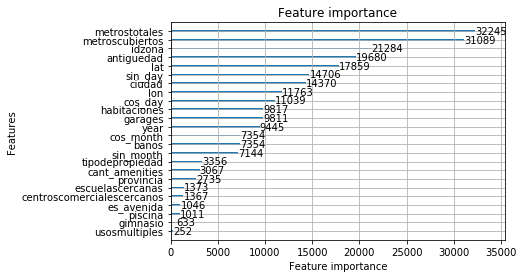

In [26]:
lgb.plot_importance(gbm_optimized);

In [27]:
selected_features = ['metrostotales','metroscubiertos','idzona', 'antiguedad', 'lat','sin_day']

In [29]:
gbm_optimized.fit(X_train[selected_features], y_train, sample_weight=None, init_score=None, eval_set=[(X_test[selected_features],y_test)], eval_names=None,
                  eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=10,
                  verbose=False, feature_name='auto',
#                   categorical_feature=['tipodepropiedad', 'ciudad','provincia'],
                  callbacks=None)

y_scores = gbm_optimized.predict(X_test[selected_features], num_iteration=gbm_optimized.best_iteration_)

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

0.3141530420172739


In [30]:
print(mean_absolute_error(np.exp(y_test), np.exp(y_scores)))

767373.746482836


In [31]:
train['ratio_cubiertos_totales'] = train['metroscubiertos']/train['metrostotales']
test['ratio_cubiertos_totales'] = test['metroscubiertos']/test['metrostotales']

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop(['precio', 'precio_log'], axis=1), train['precio_log'], test_size=0.33, random_state=seed)

In [33]:
gbm_optimized.fit(X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train, sample_weight=None, init_score=None, eval_set=[(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1),y_test)], eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=10,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)

y_scores = gbm_optimized.predict(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


0.21808874190481556


In [34]:
print(mean_absolute_error(np.exp(y_test), np.exp(y_scores)))

537134.9165997681


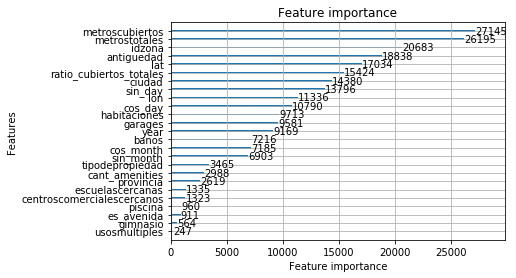

In [35]:
lgb.plot_importance(gbm_optimized);

## Entrenamiento con todos los datos para obtener predicciones a subir

In [36]:
gbm_optimized.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio','precio_log'],axis=1), train['precio_log'], sample_weight=None, init_score=None, eval_set=None, eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)


# prediciendo valores posta...
predictions = gbm_optimized.predict(test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [37]:
exp_predictions = np.exp(predictions)

In [38]:
df = pd.DataFrame(data={'id':test['id'], 'target':exp_predictions})

In [39]:
description = "22nd approach. LightGBM previous grid search. Log(precio). Agrego ratio metros cubiertos/totales"
save_submission(df, description=description)

In [ ]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [40]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_22"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio','precio_log'],axis=1).iloc[train_index], train.drop(['precio','precio_log'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio_log'][train_index], train['precio_log'][test_index]
    
    gbm_optimized.fit(X_train2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train2)
    y_scores = gbm_optimized.predict(X_test2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1))
    
    print(mean_absolute_error(y_test2, y_scores))
    print(mean_absolute_error(np.exp(y_test2), np.exp(y_scores)))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:np.exp(y_scores)}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

0.21833372821119437
537384.4849723497
0.21846163991154113
541652.4923135234
0.2183037389236226
536023.5843912873


In [ ]:
beep()

# Approach 23: XGBoost

## Entrenamiento local

In [16]:
train['precio_log'] = np.log(train['precio'])

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop(['precio', 'precio_log'], axis=1), train['precio_log'], test_size=0.33, random_state=seed)

In [20]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
xgbr = xgb.XGBRegressor(verbosity=1, objective='reg:squarederror', booster='gbtree', tree_method='auto',
                       n_jobs=-1, min_child_weight=1, max_delta_step=0, subsample=1,
                       colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0,
                       reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=seed,
                       missing=None, num_parallel_tree=1, importance_type='gain', eval_metric='mae')

In [23]:
param_dist = {"booser":['gbtree','dart'],
              "gamma":[0, 0.3, 0.7],
              "max_depth": [5,30,75],
              "learning_rate" : [0.001,0.01,0.05,0.1],
              "n_estimators": [50,100,200],
             }

grid_search = GridSearchCV(xgbr, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="neg_mean_absolute_error", verbose=5)
grid_search.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad', 'ciudad', 'provincia','precio','precio_log'],axis=1), train['precio_log'])
grid_search.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  1.2min finished
/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.b

XGBRegressor(base_score=0.5, booser='gbtree', booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             eval_metric='mae', gamma=0.3, importance_type='gain',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
             nthread=None, num_parallel_tree=1, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='auto',
             verbosity=1)

In [24]:
xgbr_optimized = grid_search.best_estimator_

In [27]:
xgbr_optimized.fit(X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad', 'ciudad', 'provincia'],axis=1),
                   y_train,
                   sample_weight=None,
                   eval_set=[(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad', 'ciudad', 'provincia'],axis=1),y_test)],
                   eval_metric='mae',
#                    early_stopping_rounds=10,
                   verbose=False,
                   callbacks=None)

In [28]:
y_scores = xgbr_optimized.predict(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad', 'ciudad', 'provincia'],axis=1))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

0.36480953773226654


In [29]:
print(mean_absolute_error(np.exp(y_test), np.exp(y_scores)))

938726.3341856061


## Entrenamiento con todos los datos para obtener predicciones a subir

In [32]:
xgbr_optimized.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad', 'ciudad', 'provincia','precio','precio_log'],axis=1),
                   train['precio_log'],
                   sample_weight=None,
                   eval_set=None,
                   eval_metric='mae',
#                    early_stopping_rounds=None,
                   verbose=False,
                   callbacks=None)


# prediciendo valores posta...
predictions = xgbr_optimized.predict(test.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad', 'ciudad', 'provincia'],axis=1))

In [33]:
exp_predictions = np.exp(predictions)

In [39]:
df = pd.DataFrame(data={'id':test['id'], 'target':exp_predictions})

In [40]:
description = "23rd approach. XGBoost with grid search. Log(precio)"
save_submission(df, description=description)

In [41]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [34]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_23"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio','precio_log'],axis=1).iloc[train_index], train.drop(['precio','precio_log'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio_log'][train_index], train['precio_log'][test_index]
    
    xgbr_optimized.fit(X_train2.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad', 'ciudad', 'provincia'],axis=1), y_train2)
    y_scores = xgbr_optimized.predict(X_test2.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad', 'ciudad', 'provincia'],axis=1))
    
    print(mean_absolute_error(y_test2, y_scores))
    print(mean_absolute_error(np.exp(y_test2), np.exp(y_scores)))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:np.exp(y_scores)}))

# df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

0.3613591569846996
935017.583177395
0.3591682434175199
936752.0129504503


/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.36431483467687015
899363.7428678678


In [43]:
beep()

# Approach 23b: XGBoost

## Entrenamiento local

In [25]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
# xgbr = xgb.XGBRegressor(verbosity=1, objective='reg:tweedie', booster='gbtree', tree_method='auto',
#                        n_jobs=-1, min_child_weight=1, max_delta_step=0, subsample=1,
#                        colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0,
#                        reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=seed,
#                        missing=None, num_parallel_tree=1, importance_type='gain', eval_metric='mae', tweedie_variance_power=2)

In [29]:
xgbr_optimized = xgb.XGBRegressor(base_score=0.5, booser='gbtree', booster='gbtree',
                                  colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
                                  eval_metric='mae', gamma=0.3, importance_type='gain',
                                  learning_rate=0.05, max_delta_step=0, max_depth=5,
                                  min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
                                  nthread=None, num_parallel_tree=1, objective='reg:tweedie',
                                  random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                                  seed=None, silent=None, subsample=1, tree_method='auto',
                                  verbosity=1, tweedie_variance_power=1.1)

In [30]:
xgbr_optimized.fit(X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad', 'ciudad', 'provincia'],axis=1),
                   y_train,
                   sample_weight=None,
                   eval_set=[(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad', 'ciudad', 'provincia'],axis=1),y_test)],
                   eval_metric='mae',
#                    early_stopping_rounds=10,
                   verbose=False,
                   callbacks=None)

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booser='gbtree', booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             eval_metric='mae', gamma=0.3, importance_type='gain',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
             nthread=None, num_parallel_tree=1, objective='reg:tweedie',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='auto',
             tweedie_variance_power=1.1, verbosity=1)

In [31]:
y_scores = xgbr_optimized.predict(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad', 'ciudad', 'provincia'],axis=1))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

744289.9625572128


## Entrenamiento con todos los datos para obtener predicciones a subir

In [32]:
xgbr_optimized.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad', 'ciudad', 'provincia','precio','precio_log'],axis=1),
                   train['precio_log'],
                   sample_weight=None,
                   eval_set=None,
                   eval_metric='mae',
#                    early_stopping_rounds=None,
                   verbose=False,
                   callbacks=None)


# prediciendo valores posta...
predictions = xgbr_optimized.predict(test.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad', 'ciudad', 'provincia'],axis=1))

In [33]:
exp_predictions = np.exp(predictions)

In [39]:
df = pd.DataFrame(data={'id':test['id'], 'target':exp_predictions})

In [40]:
description = "23rd approach. XGBoost with grid search. Log(precio)"
save_submission(df, description=description)

In [41]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [34]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_23"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio','precio_log'],axis=1).iloc[train_index], train.drop(['precio','precio_log'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio_log'][train_index], train['precio_log'][test_index]
    
    xgbr_optimized.fit(X_train2.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad', 'ciudad', 'provincia'],axis=1), y_train2)
    y_scores = xgbr_optimized.predict(X_test2.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad', 'ciudad', 'provincia'],axis=1))
    
    print(mean_absolute_error(y_test2, y_scores))
    print(mean_absolute_error(np.exp(y_test2), np.exp(y_scores)))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:np.exp(y_scores)}))

# df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

0.3613591569846996
935017.583177395
0.3591682434175199
936752.0129504503


/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.36431483467687015
899363.7428678678


In [43]:
beep()

# Approach 24: LightGBM with log price, grid search and new features

## New features

In [16]:
from scipy.stats import skew

In [17]:
train.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lon', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio', 'cant_amenities', 'es_avenida',
       'year', 'sin_month', 'cos_month', 'sin_day', 'cos_day'],
      dtype='object')

In [18]:
variables = ['tipodepropiedad','ciudad','provincia']

In [43]:
stats = []
for var_bajo_estudio in variables:
    print(train[var_bajo_estudio].nunique())
    new_stats = train.drop(['id','idzona'],axis=1).groupby(var_bajo_estudio, as_index=False).agg(['mean','min','max','std'])
    new_stats.columns = ['_'.join(col).strip("_") for col in new_stats.columns.values]
    new_stats = new_stats.add_prefix(var_bajo_estudio + "_")
    new_stats = new_stats.reset_index()
    stats.append(new_stats)

24
875
32


In [27]:
train.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lon,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,cant_amenities,es_avenida,year,sin_month,cos_month,sin_day,cos_day
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,NaN,2.0,1.0,2.0,80.0,80.0,23536.0,31.733330,-106.48333,2015-08-23,False,False,False,False,False,2273000.0,0,True,2015,-8.660254e-01,-5.000000e-01,-0.998717,-0.050649
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.0,3.0,2.0,2.0,268.0,180.0,24512.0,19.312500,-99.25000,2013-06-28,False,False,False,True,True,3600000.0,2,True,2013,1.224647e-16,-1.000000e+00,-0.571268,0.820763
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.0,3.0,2.0,2.0,144.0,166.0,48544.0,NaN,NaN,2015-10-17,False,False,False,False,False,1200000.0,0,False,2015,-8.660254e-01,5.000000e-01,-0.299363,-0.954139
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.0,2.0,1.0,1.0,63.0,67.0,53664.0,19.296875,-99.68750,2012-03-09,False,False,False,True,True,650000.0,2,False,2012,1.000000e+00,6.123234e-17,0.968077,-0.250653
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.0,2.0,1.0,1.0,95.0,95.0,47840.0,20.723560,-103.38479,2016-06-07,False,False,False,False,False,1150000.0,0,False,2016,1.224647e-16,-1.000000e+00,0.988468,0.151428


In [48]:
for stat in stats:
    train = train.merge(stat, on=stat.columns[0], how='left')
    test = test.merge(stat, on=stat.columns[0], how='left')

In [49]:
print(train.shape)
print(test.shape)

(240000, 282)
(60000, 281)


## Entrenamiento local

In [50]:
train['precio_log'] = np.log(train['precio'])

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop(['precio', 'precio_log'], axis=1), train['precio_log'], test_size=0.33, random_state=seed)

In [53]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

gbm_optimized = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=25,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=300, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [69]:
gbm_optimized.fit(X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1).select_dtypes('number'),
                  y_train,
                  sample_weight=None,
                  init_score=None,
                  eval_set=[(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1).select_dtypes('number'),y_test)],
                  eval_names=None,
                  eval_sample_weight=None,
                  eval_init_score=None,
                  eval_metric='mae',
                  early_stopping_rounds=10,
                  verbose=False,
                  feature_name='auto',
#                   categorical_feature=['tipodepropiedad', 'ciudad','provincia'],
                  callbacks=None)

y_scores = gbm_optimized.predict(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1).select_dtypes('number'),
                                 num_iteration=gbm_optimized.best_iteration_)

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

0.23103197053238284


In [70]:
print(mean_absolute_error(np.exp(y_test), np.exp(y_scores)))

571821.2012699873


## Entrenamiento con todos los datos para obtener predicciones a subir

In [71]:
gbm_optimized.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio','precio_log'],axis=1).select_dtypes('number'),
                  train['precio_log'],
                  sample_weight=None, init_score=None, eval_set=None, eval_names=None,
                  eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
                  verbose=False, feature_name='auto',
#                   categorical_feature=['tipodepropiedad', 'ciudad','provincia'],
                  callbacks=None)


# prediciendo valores posta...
predictions = gbm_optimized.predict(test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1).select_dtypes('number'),
                                    num_iteration=gbm_optimized.best_iteration_)

In [72]:
exp_predictions = np.exp(predictions)

In [73]:
df = pd.DataFrame(data={'id':test['id'], 'target':exp_predictions})

In [74]:
description = "24th approach. LightGBM with new features. Log(precio)"
save_submission(df, description=description)

In [41]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [75]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_24"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio','precio_log'],axis=1).iloc[train_index], train.drop(['precio','precio_log'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio_log'][train_index], train['precio_log'][test_index]
    
    gbm_optimized.fit(X_train2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1).select_dtypes('number'), y_train2)
    y_scores = gbm_optimized.predict(X_test2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1).select_dtypes('number'))
    
    print(mean_absolute_error(y_test2, y_scores))
    print(mean_absolute_error(np.exp(y_test2), np.exp(y_scores)))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:np.exp(y_scores)}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

0.23109852053084437
571134.9749524965
0.23198280034021654
577656.1047017883
0.2322349153536218
572334.5455831354


In [43]:
beep()

# Approach 25: LightGBM

## Entrenamiento local

In [42]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1,
                        n_estimators=100, subsample_for_bin=200000, objective='tweedie',
                        class_weight=None, min_split_gain=0.0, min_child_weight=0.001,
                        min_child_samples=20, subsample=1.0, subsample_freq=0,
                        colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,
                        random_state=seed, n_jobs=-1, silent=True, importance_type='split')

In [43]:
gbm.fit(X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train, sample_weight=None, init_score=None, eval_set=[(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1),y_test)], eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=10,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)

y_scores = gbm.predict(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm.best_iteration_)

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


589800.1725394047


In [44]:
beep()

## Entrenamiento con todos los datos para obtener predicciones a subir

In [49]:
test['year'].value_counts()

2016    23474
2015    13017
2014    10018
2013     7592
2012     5899
Name: year, dtype: int64

In [50]:
train['year'].value_counts()

2016    94038
2015    51470
2014    40572
2013    30386
2012    23534
Name: year, dtype: int64

In [45]:
gbm.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio'],axis=1), train['precio'], sample_weight=None, init_score=None, eval_set=None, eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)


# prediciendo valores posta...
predictions = gbm.predict(test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm.best_iteration_)

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [46]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [47]:
description = "25th approach. LightGBM"
save_submission(df, description=description)

In [48]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [33]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_7"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    gbm.fit(X_train2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train2)
    y_scores = gbm.predict(X_test2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

601903.1787852186
606405.0221414941
602955.8643765596


In [30]:
beep()

# Approach 26: LightGBM with dolar prices

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop(['precio','precio_dolares'], axis=1), train['precio_dolares'], test_size=0.33, random_state=seed)

## Entrenamiento local

In [51]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
gbm = lgb.LGBMRegressor(silent=False)

param_dist = {"max_depth": [25,50, 75],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [300,900,1200],
              "n_estimators": [50,100,200]
             }

grid_search = GridSearchCV(gbm, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="neg_mean_absolute_error", verbose=5)
grid_search.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio','precio_dolares'],axis=1), train['precio_dolares'])
grid_search.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 32.8min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 49.2min finished


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=25,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=1200, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [52]:
import lightgbm as lgb
gbm = grid_search.best_estimator_

In [53]:
gbm.fit(X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train, sample_weight=None, init_score=None,
        eval_set=[(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1),y_test)], eval_names=None,
        eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=10,
        verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)

y_scores = gbm.predict(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm.best_iteration_)

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


34221.19554828463


In [54]:
df1 = pd.DataFrame(data={'id':X_test['id'], 'target':y_scores}).merge(cotizaciones_train, how='left')

df1['target'] = df1['target'] * df1['cotizacion_dolar']
df1.drop(['cotizacion_dolar'], axis=1, inplace=True)
df1.head()

,id,target
0,65506,3.343963e+06
1,15099,2.373867e+06
2,236537,6.585675e+06
3,252792,4.351863e+06
4,81149,5.032944e+05


In [55]:
df2 = pd.DataFrame(data={'id':X_test['id'], 'target':y_test}).merge(cotizaciones_train, how='left')

df2['target'] = df2['target'] * df2['cotizacion_dolar']
df2.drop(['cotizacion_dolar'], axis=1, inplace=True)
df2.head()

,id,target
0,65506,3250000.0
1,15099,2700000.0
2,236537,8800000.0
3,252792,5350000.0
4,81149,400000.0


In [56]:
print(mean_absolute_error(df2['target'], df1['target']))

544309.8572782938


In [50]:
print(mean_absolute_error(df2['target'], df1['target']))

544309.8572782938


In [30]:
beep()

## Entrenamiento con todos los datos para obtener predicciones a subir

In [ ]:
gbm.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio','precio_dolares'],axis=1), train['precio_dolares'],
        sample_weight=None, init_score=None, eval_set=None, eval_names=None,
        eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
        verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)


# prediciendo valores posta...
predictions = gbm.predict(test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm.best_iteration_)

In [ ]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [ ]:
df = df.merge(cotizaciones_test, how='left')
df['target'] = df['target'] * df['cotizacion_dolar']
df.drop(['cotizacion_dolar'], axis=1, inplace=True)
df.head()

In [ ]:
description = "26th approach. LightGBM. Grid search. Precio en dolares."
save_submission(df, description=description)

In [ ]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_7"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    gbm.fit(X_train2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train2)
    y_scores = gbm.predict(X_test2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

In [ ]:
beep()